<a href="https://colab.research.google.com/github/vipulsurw/Green-Spaces-CoL/blob/main/green_spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import geopandas as gpd
import pandas as pd
fp = 'district_borough_unitary_region.shp'
df = gpd.read_file(fp)

In [ ]:
df.head()

In [3]:
col_districts = [
    'City and County of the City of London',
]
# Filtering to City of London
col_boroughs = df[df['NAME'].isin(col_districts)]

In [4]:
col_boroughs.head()

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
266,City and County of the City of London,LBO,London Borough,GREATER_LONDON_AUTHORITY,267,267,22705,22705,E09000001,314.688,25.72,AA,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((532140.296 182191.897, 532141.185 18..."


In [24]:
#converting coordinate system for better projection
col_boroughs.to_crs(epsg=3857, inplace=True)


In [25]:
#importing green spaces file into geodataframe (TQ is the quandrant of the City)
fp = 'TQ_GreenspaceSite.shp'
gs_tq = gpd.read_file(fp)
gs = gpd.GeoDataFrame(gs_tq)


In [31]:
gs.to_crs(epsg=3857, inplace=True)

In [32]:
#list of features in green spaces geodataframe

function_types = [
 'Allotments or Community Growing Spaces',
 'Bowling Green',
 'Cemetery',
 'Religious Grounds',
 'Golf Course',
 'Other Sports Facility',
 'Play Space',
 'Playing Field',
 'Public Park or Garden',
 'Tennis Court'

]
gs = gs[gs['function'].isin(function_types)]

In [33]:
# Filtering down to green spaces in City of London
col_gs = gpd.overlay(col_boroughs, gs, how='intersection')

<Axes: >

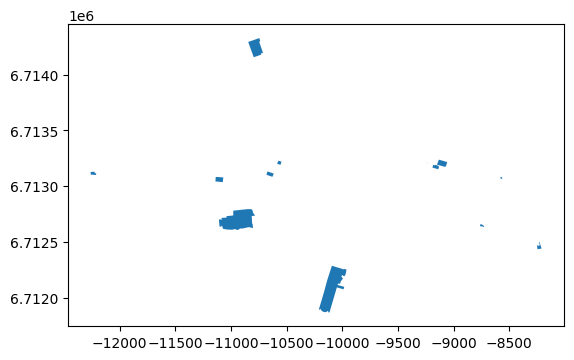

In [34]:
col_gs.plot()

In [35]:
col_boroughs = col_boroughs.to_crs(epsg=27700)
col_gs = col_gs.to_crs(epsg=27700)

In [36]:
col_boroughs = col_boroughs.to_crs(epsg=3857)
col_gs = col_gs.to_crs(epsg=3857)
#col = col.to_crs(epsg=3857)

In [ ]:
!pip install contextily

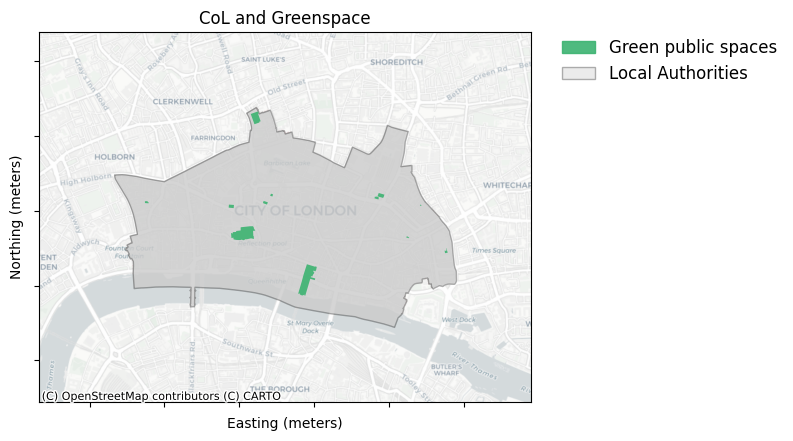

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import contextily as cx
import matplotlib.patches as mpatches


# Define City of London polygon
col = gpd.GeoSeries(unary_union(col_boroughs.geometry))

# Define bounding box
bounds = col.bounds
bounding_box = [
    bounds.minx[0],
    bounds.maxx[0],
    bounds.miny[0],
    bounds.maxy[0],
]

# Create a plot
fig, ax = plt.subplots()

# Set plot limits with buffer
ax.set_xlim(bounding_box[0] - 1000, bounding_box[1] + 1000)
ax.set_ylim(bounding_box[2] - 1000, bounding_box[3] + 1000)

# Plot the City of London polygon
col.plot(ax=ax, color='lightgray', alpha=0.7)

# Plot borough borders
col_boroughs.plot(
    ax=ax,
    alpha=0.3,
    edgecolor='black',
    facecolor='silver'
)

# Plot the green spaces
col_gs.plot(
    ax=ax,
    alpha=0.9,
    color='mediumseagreen',
    label='Green Open Spaces'
)

# Add background map
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Remove axis labels
ax.set_yticklabels([])
ax.set_xticklabels([])

# Add labels and title
ax.set_xlabel('Easting (meters)')
ax.set_ylabel('Northing (meters)')
ax.set_title('CoL and Greenspace')

# Add legend
green_patch = mpatches.Patch(color='mediumseagreen', alpha=0.9, label='Green public spaces')
gray_patch = mpatches.Patch(facecolor='silver', edgecolor='black', alpha=0.3, label='Local Authorities')
leg = plt.legend(
    handles=[green_patch, gray_patch],
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.,
    frameon=False,
    prop={'size': 12}
)

plt.show()


In [15]:
# UK Postal Sector boundaries
fp = 'PostalSector.shp'
ps = gpd.read_file(fp)
ps.to_crs(epsg=3857, inplace=True)
# Filter by postal sectors in City of London
col_ps = gpd.overlay(col_boroughs, ps, how='intersection')

In [16]:
col_expanded_ps = col_ps.copy()
col_expanded_ps['geometry'] = col_expanded_ps['geometry'].apply(lambda geo: geo.buffer(800))

In [17]:
col_expanded_ps.to_crs(epsg=6933, inplace=True)
col_gs_ease = col_gs.copy()
col_gs_ease.to_crs(epsg=6933, inplace=True)

In [18]:
col_expanded_ps['green_area_sq_km'] = 0.0
for i, postal_sectors in col_expanded_ps.iterrows():
    for j, green_space in enumerate(col_gs_ease['geometry']):
        green_area_in_postal_sector = postal_sectors['geometry'].intersection(green_space)
        col_expanded_ps.at[i, 'green_area_sq_km'] += green_area_in_postal_sector.area / 10**6 # squared km
col_expanded_ps['green_area_ha'] = col_expanded_ps['green_area_sq_km'] * 100
col_expanded_ps['green_area_sq_m'] = col_expanded_ps['green_area_sq_km'] * 1000000

In [19]:
col_ps = pd.merge(
    col_ps,
    col_expanded_ps,
    how='left',
    on='RMSect',
)

In [20]:
import numpy as np
pop = pd.read_csv(
    'bulk.csv',
    skiprows=11,
    names=['area','population'],
)
#col_ps.columns()
pop.head()


area  population
2011 AL2  3 AL2  3 Total 7967 3877 4090 7863 104 168  2284.36         3.5
     AL3  4 AL3  4 Total 5565 2763 2802 5500 65  131   302.42        18.4
     AL3  5 AL3  5 Total 8831 4200 4631 8604 227 173   228.02        38.7
     AL3  6 AL3  6 Total 4281 2070 2211 4271 10  81   1400.81         3.1
     AL3  7 AL3  7 Total 5344 2582 2762 5284 60  85   1908.57         2.8

In [21]:
import numpy as np
pop = pd.read_csv(
    'bulk.csv',
    skiprows=11,
    names=['area','population'],
)


if pd.api.types.is_string_dtype(pop['area']):
  pop['StrSect'] = pop['area'].str[7:].str.replace(' ','')
else:
  # Handle non-string case (e.g., assign missing values)
  pop['StrSect'] = np.nan
  pop.drop('area', axis=1, inplace=True)
# converting population to numeric
pop = pop[:-4]
pop['population'] = pop['population'].apply(pd.to_numeric)

In [22]:
col_ps = pd.merge(
    col_ps,
    pop,
    how='left',
    on='StrSect',
)
# calculate area/inhabitants ratio
col_ps['green_area_sq_m_pp'] = col_ps['green_area_sq_m']/col_ps['population']

KeyError: 'StrSect'

In [ ]:
# Plot green areas access
vmin, vmax = 0, 1200
col_ps.plot(
    ax=ax,
    column='green_area_sq_m_pp',
    cmap='hot_r',
    vmin=vmin,
    vmax=vmax,
    alpha=0.7,
)